# NE 630 - Lesson 33 

This notebook provides some symbolically worked examples that aim to show solutions (and *not* algebra!).

# Example 1

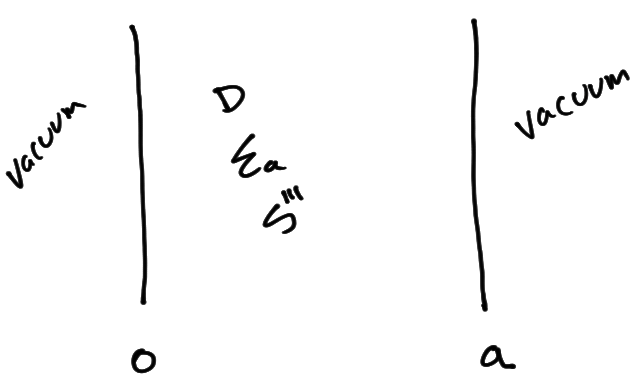

Model the vacuum conditions using (1) $\phi = 0$ and (2) $J^{\text{in}} = 0$ and determine $\phi(x)$.  Then, plot the two results for $a = 10$ cm, $D = 1$ cm, $\Sigma_a = 0.1$ cm, and $s'''(x) = 1$ 1/cm$^3$-s.

In [1]:
import sympy as sy

In [2]:
D, Sigma_a, L, s, a = sy.symbols("D, Sigma_a, L, s''', a", positive=True)
x = sy.symbols("x", real=True)
phi = sy.Function("phi")

Define the diffusion equation:

In [3]:
nde = sy.Eq(-sy.diff(phi(x), x, 2)+(1/L**2)*phi(x), s/D)
nde

Eq(-Derivative(phi(x), (x, 2)) + phi(x)/L**2, s'''/D)

Determine the solution (homogeneous plus particular):

In [4]:
sol = sy.dsolve(nde)
phi_sol = sol.rhs
phi_sol

C1*exp(-x/L) + C2*exp(x/L) + L**2*s'''/D

Also define the partial currents

In [5]:
J_right = sol.rhs/4 - (D/2)*sy.diff(sol.rhs, x)
J_left = sol.rhs/4 + (D/2)*sy.diff(sol.rhs, x)
J_right 

C1*exp(-x/L)/4 + C2*exp(x/L)/4 - D*(-C1*exp(-x/L)/L + C2*exp(x/L)/L)/2 + L**2*s'''/(4*D)

Define the (zero-flux) boundary conditions:

In [6]:
bc_L_zeroflux = sy.Eq(phi_sol.subs(x, 0), 0)
bc_L_zeroflux

Eq(C1 + C2 + L**2*s'''/D, 0)

In [7]:
bc_R_zeroflux = sy.Eq(phi_sol.subs(x, a), 0)
bc_R_zeroflux

Eq(C1*exp(-a/L) + C2*exp(a/L) + L**2*s'''/D, 0)

Or, in matrix form, we have

In [8]:
C1, C2 = sy.symbols("C1, C2")
M = sy.linear_eq_to_matrix([bc_L_zeroflux, bc_R_zeroflux], C1, C2)[0]
sy.Eq(sy.MatMul(M, sy.Matrix([C1, C2])), sy.Matrix([-L**2*s/D, -L**2*s/D]))

Eq(Matrix([
[        1,        1],
[exp(-a/L), exp(a/L)]])*Matrix([
[C1],
[C2]]), Matrix([
[-L**2*s'''/D],
[-L**2*s'''/D]]))

Now, if we were doing this by hand and got to this point, we could use NumPy to get $C_1$ and $C_2$:

In [9]:
import numpy as np

L_val = np.sqrt(1/.1)

M = np.array([[1, 1],
              [np.exp(-10.0/L_val), np.exp(10.0/L_val)]])
rhs = np.array([-L_val**2, -L_val**2]) # the boundary values
np.linalg.solve(M, rhs)

array([-9.59389779, -0.40610221])

Now, do the same with partial currents:

In [10]:
bc_L_zeropcur = sy.Eq(J_right.subs(x, 0), 0)
bc_R_zeropcur = sy.Eq(J_left.subs(x, a), 0)
M = sy.linear_eq_to_matrix([bc_L_zeropcur, bc_R_zeropcur], C1, C2)[0]
sy.Eq(sy.MatMul(M, sy.Matrix([C1, C2])),  sy.Matrix([-L**2*s/D, -L**2*s/D]))

Eq(Matrix([
[                   D/(2*L) + 1/4,                -D/(2*L) + 1/4],
[-D*exp(-a/L)/(2*L) + exp(-a/L)/4, D*exp(a/L)/(2*L) + exp(a/L)/4]])*Matrix([
[C1],
[C2]]), Matrix([
[-L**2*s'''/D],
[-L**2*s'''/D]]))

Solve for the coefficients and substitute into the solution:

In [11]:
coefs_zero = sy.solve([bc_L_zeroflux, bc_R_zeroflux], C1, C2)
coefs_zero[C2]

-L**2*s'''/(D*exp(a/L) + D)

In [12]:
num_data = {a: 10, D: 1, Sigma_a: 0.1, s: 1, L: sy.sqrt(1/0.1)}
phi_zero = phi_sol.subs(coefs_zero).subs(num_data)
phi_zero

-0.406102206733749*exp(0.316227766016838*x) + 10.0 - 9.59389779326625*exp(-0.316227766016838*x)

In [13]:
coefs_zeropcur = sy.solve([bc_L_zeropcur, bc_R_zeropcur], C1, C2)
coefs_zeropcur[C2]

-L**3*s'''/(2*D**2*exp(a/L) - 2*D**2 + D*L*exp(a/L) + D*L)

In [14]:
phi_zeropcur = phi_sol.subs(coefs_zeropcur).subs(num_data)
phi_zeropcur

-0.256849971960043*exp(0.316227766016838*x) + 10.0 - 6.06791181709471*exp(-0.316227766016838*x)

Finally, plot the results:

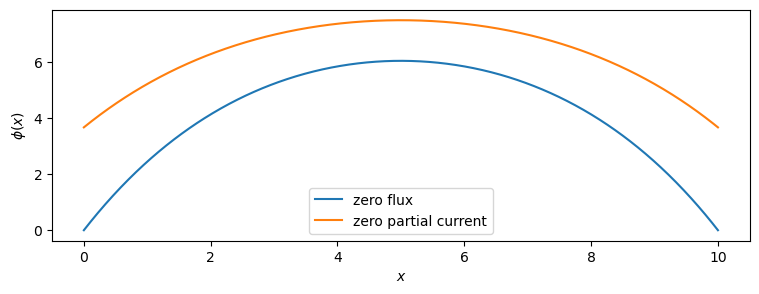

In [15]:
import numpy as np
import matplotlib.pyplot as plt
x_vals = np.linspace(0, 10, 1000)
phi_zero_plot = sy.lambdify(x, phi_zero) # turn sympy expression with "x" into python function of x
phi_zeropcur_plot = sy.lambdify(x, phi_zeropcur)
plt.figure(figsize=(9,3))
plt.plot(x_vals, phi_zero_plot(x_vals), label="zero flux")
plt.plot(x_vals, phi_zeropcur_plot(x_vals), label="zero partial current")
plt.ylabel("$\phi(x)$")
plt.xlabel("$x$")
plt.legend();

Obviously, this is a **huge** difference!  The reason for such a large difference is because the slab dimension is just 10 cm.  Recall that $D = 1/(3\Sigma_t) \rightarrow \Sigma_t = 1/(3D) = 1/3$ [1/cm], so the mean free path $\lambda = 3$ cm!  That means many neutrons leak out.  In fact, if we compute the net current at the boundaries, we'll find that, for the zero-flux case, there is a *negative* in flow:

In [16]:
phi_zero.subs(x, 0)/4-0.5*sy.diff(phi_zero, x).subs(x, 0)

-1.45271803647427

Things get much more similar throughout the middle, though, if we make the slab 5 times as large:

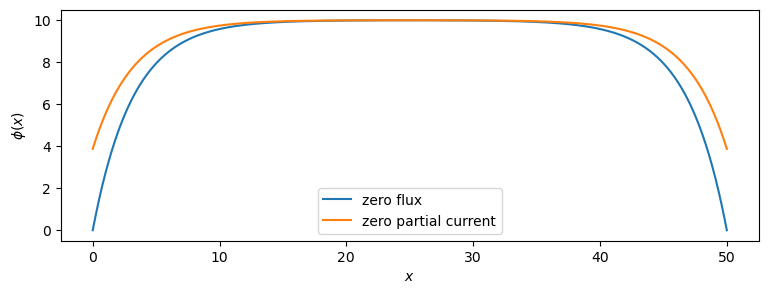

In [17]:
num_data = {a: 50, D: 1, Sigma_a: 0.1, s: 1, L: sy.sqrt(1/0.1)}
x_vals = np.linspace(0, 50, 1000)
phi_zero = phi_sol.subs(coefs_zero).subs(num_data)
phi_zeropcur = phi_sol.subs(coefs_zeropcur).subs(num_data)
phi_zero_plot = sy.lambdify(x, phi_zero) # turn sympy expression with "x" into python function of x
phi_zeropcur_plot = sy.lambdify(x, phi_zeropcur)
plt.figure(figsize=(9,3))
plt.plot(x_vals, phi_zero_plot(x_vals), label="zero flux")
plt.plot(x_vals, phi_zeropcur_plot(x_vals), label="zero partial current")
plt.ylabel("$\phi(x)$")
plt.xlabel("$x$")
plt.legend();

Can you figure out what the flux value approaches in the middle of this slab?

# Example 2

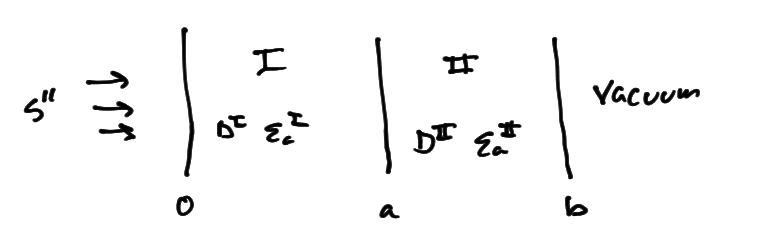

Determine $\phi(x)$.

First, some imports and symbol definitions:

In [18]:
import sympy as sy
D_I, L_I, D_II, L_II, s, a, b = sy.symbols("D_I, L_I, D_II, L_II, s'', a, b", positive=True)
C1, C2, C3, C4 = sy.symbols("C1, C2, C3, C4")
x = sy.symbols("x", real=True)
phi = sy.Function("phi")

Define the NDE in each region:

In [19]:
nde_I = sy.Eq(-sy.diff(phi(x), x, 2)+(1/L_I**2)*phi(x), 0)
nde_II = sy.Eq(-sy.diff(phi(x), x, 2)+(1/L_II**2)*phi(x), 0)

Get the solution in each region (note, there is no particular solution here since there is no source term):

In [20]:
phi_sol_I = sy.dsolve(nde_I).rhs
phi_sol_I

C1*exp(-x/L_I) + C2*exp(x/L_I)

In [21]:
phi_sol_II = sy.dsolve(nde_II).rhs.subs(C1, C3).subs(C2, C4)
phi_sol_II

C3*exp(-x/L_II) + C4*exp(x/L_II)

Define the rightward partial current in region I, the leftward partial current in region II, and the net current in both:

In [22]:
J_right_I = phi_sol_I/4 - (D_I/2)*sy.diff(phi_sol_I, x)
J_left_II = phi_sol_II/4 + (D_II/2)*sy.diff(phi_sol_II, x)

J_I = -D_I*sy.diff(phi_sol_I, x)
J_II = -D_II*sy.diff(phi_sol_II, x)

Define each boundary and continuity condition:

In [23]:
bc_L = sy.Eq(J_right_I.subs(x, 0), s)
bc_R = sy.Eq(J_left_II.subs(x, b), 0)

cc_phi = sy.Eq(phi_sol_I.subs(x, a), phi_sol_II.subs(x, a))
cc_J   = sy.Eq(J_I.subs(x, a), J_II.subs(x, a))

In [24]:
bc_L

Eq(C1/4 + C2/4 - D_I*(-C1/L_I + C2/L_I)/2, s'')

In [25]:
bc_R

Eq(C3*exp(-b/L_II)/4 + C4*exp(b/L_II)/4 + D_II*(-C3*exp(-b/L_II)/L_II + C4*exp(b/L_II)/L_II)/2, 0)

In [26]:
cc_phi

Eq(C1*exp(-a/L_I) + C2*exp(a/L_I), C3*exp(-a/L_II) + C4*exp(a/L_II))

In [27]:
cc_J

Eq(-D_I*(-C1*exp(-a/L_I)/L_I + C2*exp(a/L_I)/L_I), -D_II*(-C3*exp(-a/L_II)/L_II + C4*exp(a/L_II)/L_II))

Even with sympy, solving for the unknown coefficients leads to a nasty mess!  Rather, let's set up the matrix equation, which is something you should be able to do by hand.

In [28]:
A, rhs = sy.linear_eq_to_matrix([bc_L, bc_R, cc_phi, cc_J], C1, C2, C3, C4)

In [29]:
sy.Eq(sy.MatMul(A, sy.Matrix([C1, C2, C3, C4])), rhs)

Eq(Matrix([
[  D_I/(2*L_I) + 1/4,  -D_I/(2*L_I) + 1/4,                                            0,                                         0],
[                  0,                   0, -D_II*exp(-b/L_II)/(2*L_II) + exp(-b/L_II)/4, D_II*exp(b/L_II)/(2*L_II) + exp(b/L_II)/4],
[        exp(-a/L_I),          exp(a/L_I),                                -exp(-a/L_II),                              -exp(a/L_II)],
[D_I*exp(-a/L_I)/L_I, -D_I*exp(a/L_I)/L_I,                      -D_II*exp(-a/L_II)/L_II,                     D_II*exp(a/L_II)/L_II]])*Matrix([
[C1],
[C2],
[C3],
[C4]]), Matrix([
[s''],
[  0],
[  0],
[  0]]))

From here, we would
 
 - Substitute numbers into this matrix and the right-hand side for each parameter
 - Solve with `np.linalg.solve` or equivalent to get the numerical values of the 
   vector $\mathbf{C}$.
 - Substitute numbers (including the now-determined coefficients) into $\phi_I$ and $\phi_{II}$

In [30]:
import numpy as np
D1 = 1.0; D2 = 1.5; SigA1 = 0.2; SigA2 = 0.02; L1 = np.sqrt(D1/SigA1); L2 = np.sqrt(D2/SigA2); a=10; b=20;

In [31]:
matrix = np.array([
  [0.5*D1/L1+0.25,  -0.5*D1/L1+0.25, 0, 0],
  [0.0,  0.0, -0.5*D2*np.exp(-b/L2)/L2+0.25*np.exp(-b/L2), 0.5*D2*np.exp(b/L2)/L2+0.25*np.exp(b/L2)],
  [np.exp(-a/L1),  np.exp(a/L1), -np.exp(-a/L2), -np.exp(a/L2)],
  [D1*np.exp(-a/L1)/L1,  -D1*np.exp(a/L1)/L1, -D2**np.exp(-a/L2)/L2, D2*np.exp(a/L2)/L2]])
rhs = np.array([1, 0, 0, 0])
C = np.linalg.solve(matrix, rhs)
C

array([ 2.11145616e+00,  3.12389224e-07,  8.04990474e-02, -3.85476905e-04])

In [32]:
phi_sol_II

C3*exp(-x/L_II) + C4*exp(x/L_II)

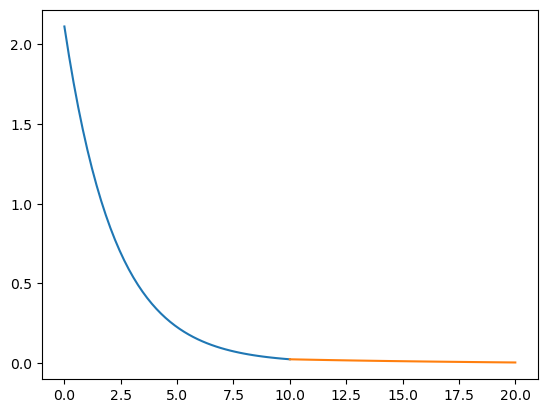

In [33]:
phi_I = lambda x: C[0]*np.exp(-x/L1) + C[1]*np.exp(x/L1)
phi_II = lambda x: C[2]*np.exp(-x/L2) + C[3]*np.exp(x/L2)

x_I = np.linspace(0, 10)
plt.plot(x_I, phi_I(x_I))
x_II = np.linspace(10, 20)
plt.plot(x_II, phi_II(x_II))